In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_targetpixelfile
from lightkurve import prf

import os
import glob
import pandas as pd
from astroquery.mast import Catalogs

import sys
sys.path.insert(0, '../../kepler/so/raDec2Pix/Kepler-RaDex2Pix')
import raDec2Pix

sys.path.insert(0, '../transit-diffImage/code')
import keplerDiffImage as kdi
import keplerApp as app


In [2]:
koi = 109.01
koiName = "Kepler-132d"
# quarterList = [1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16]
quarterList = [4, 6, 7, 8, 10, 11, 12, 14, 15, 16]
starList = [0, 1]
starNames = ['E', 'W']

In [3]:
standardDepth = 1e-3

In [4]:
rdp = raDec2Pix.raDec2PixClass("../../kepler/so/raDec2Pix/Kepler-RaDex2Pix/raDec2PixDir")
koiData = kdi.get_koi_data(koi)

transitModelFileName = "../../kepler/so/pixelModeling/Kepler_TCE_DV_DR25_wget.bat"
transitModel = kdi.get_dv_model(koiData, transitModelFileName)

mjdOffset = 54832.5

allDiffImage = []
allDiffImageFlat = np.array([])
allDiffImageSigma = []
allDiffImageSigmaFlat = np.array([])
allSimDiffImage = {}
allSimDiffImageFlat = {}
for s in range(len(starList)):
    allSimDiffImage[s] = []
    allSimDiffImageFlat[s] = np.array([])
    
quarterDataList = []
for quarter in quarterList:
    tpf = search_targetpixelfile('KIC ' + str(koiData["kepid"]), quarter = quarter, exptime="long").download();

    quarterData = {}
    quarterData["quarter"] = quarter
    # extract the data fields from the tpf object without the hdu field for serialization
    quarterData["tpf"] = tpf;

    quarterData["extent"] = (quarterData["tpf"].column-0.5, quarterData["tpf"].column + quarterData["tpf"].shape[2]-0.5, quarterData["tpf"].row-0.5, quarterData["tpf"].row + quarterData["tpf"].shape[1]-0.5)

    # BKJD = BJD-2454833.0, MJD = JD-2400000.5, so MJD = BKJD + 2454833.0 - 2400000.5 = BKJD + 54832.5
    quarterData["meanMjd"] = np.mean(quarterData["tpf"].time.bkjd) + mjdOffset  
    print("meanMjd = " + str(quarterData["meanMjd"]))

    diffImageObject = kdi.keplerDiffImage(tpf, koiData)

    # Find the transits and compute the difference image averaged over the transits.  Draw them.
    quarterData["diffImageData"] = diffImageObject.find_transits(transitModel)
    
    diffImage = quarterData["diffImageData"]["diffImage"] - np.nanmin(quarterData["diffImageData"]["diffImage"])
    nanMask = ~np.isnan(diffImage.flatten())
    allDiffImage.append(diffImage)
    allDiffImageFlat = np.append(allDiffImageFlat, diffImage.flatten()[nanMask])
    
    diffImageSigma = quarterData["diffImageData"]["diffImageSigma"]
    allDiffImageSigma.append(diffImageSigma)
    allDiffImageSigmaFlat = np.append(allDiffImageSigmaFlat, diffImageSigma.flatten()[nanMask])

    quarterData["diffImageObject"] = diffImageObject
    quarterData["gaiaCatalog"] = kdi.get_gaia_catalog(quarterData["tpf"], quarterData["meanMjd"], rdp)

    # Set up image modeling with the Kepler PRF
    kepprf = prf.KeplerPRF(channel=quarterData["tpf"].channel, shape=quarterData["diffImageData"]["meanOutTransit"].shape,
                         column=quarterData["tpf"].column-0.5, row=quarterData["tpf"].row-0.5)
    prfExtent = (kepprf.column, kepprf.column + kepprf.shape[1], kepprf.row, kepprf.row + kepprf.shape[0])

    simOutTransitImage = np.flipud(app.make_simulated_image(quarterData["gaiaCatalog"], kepprf))
    for star in starList:
        simInTransitImage = np.flipud(app.make_simulated_image(quarterData["gaiaCatalog"], kepprf, starIndex = star, depth = standardDepth))
        simDiffImage = simOutTransitImage-simInTransitImage
        allSimDiffImage[star].append(simDiffImage)
        allSimDiffImageFlat[star] = np.append(allSimDiffImageFlat[star], simDiffImage.flatten()[nanMask])

    
    quarterDataList.append(quarterData)

{'dec': 41.34304,
 'disposition': 'CANDIDATE',
 'durationHours': 3.516,
 'epoch': 179.42137,
 'galacticLatitude': 17.266622305192886,
 'kepid': 6021275,
 'kepmag': 11.818,
 'koiNum': 'K00284.01',
 'observedDepth': 0.00017769999999999998,
 'otherPlanetList': [{'durationHours': 3.3629,
                      'epoch': 169.64044,
                      'koiNum': 'K00284.02',
                      'period': 6.41491277},
                     {'durationHours': 3.2601,
                      'epoch': 168.8626,
                      'koiNum': 'K00284.03',
                      'period': 6.17817366},
                     {'durationHours': 4.427,
                      'epoch': 239.22128,
                      'koiNum': 'K00284.04',
                      'period': 110.2867031}],
 'period': 18.01019956,
 'ra': 283.23581,
 'tceNum': 2}
../../kepler/so/pixelModeling/Kepler_TCE_DV_DR25_wget.bat
<_io.BufferedReader name=79>
wget -O 'kplr006021275-20160128150956_dvt.fits' 'http://exoplanetarchive.ipac.calt

/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 55416.898522296346


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:368: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.inTransitIndices = np.unique(sum(np.array(self.inTransitIndices).tolist(), [])).astype(int)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:369: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.outTransitIndices = np.unique(sum(np.array(self.outTransitIndices).tolist(), [])).astype(int)


INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 55507.100530209966


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 55601.58180028346


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 55786.091931377756


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:368: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.inTransitIndices = np.unique(sum(np.array(self.inTransitIndices).tolist(), [])).astype(int)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:369: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.outTransitIndices = np.unique(sum(np.array(self.outTransitIndices).tolist(), [])).astype(int)


INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 55881.663213147636


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 55972.75417375936


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 56157.179123648224


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:369: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.outTransitIndices = np.unique(sum(np.array(self.outTransitIndices).tolist(), [])).astype(int)


INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 56255.17746361371


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]
meanMjd = 56352.375059131475


/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:378: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(self.tpf.flux[inTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:379: RuntimeWarning: Mean of empty slice
  meanInTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[inTransitIndices,::-1,:].value**2, axis=0)/len(inTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:380: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(self.tpf.flux[outTransitIndices,::-1,:].value, axis=0)
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/code/keplerDiffImage.py:381: RuntimeWarning: Mean of empty slice
  meanOutTransitSigma = np.sqrt(np.nanmean(self.tpf.flux_err[outTransitIndices,::-1,:].value**2, axis=0)/len(outTransitIndices))
/Volumes/meow/steve/work/tess/transit-APP/../transit-diffImage/co

INFO: Query finished. [astroquery.utils.tap.core]


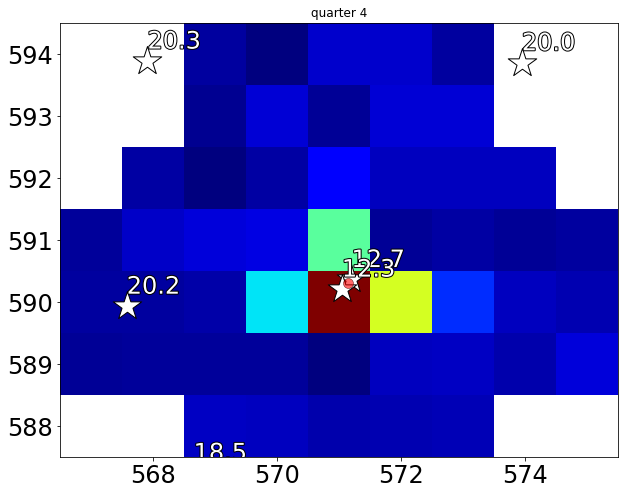

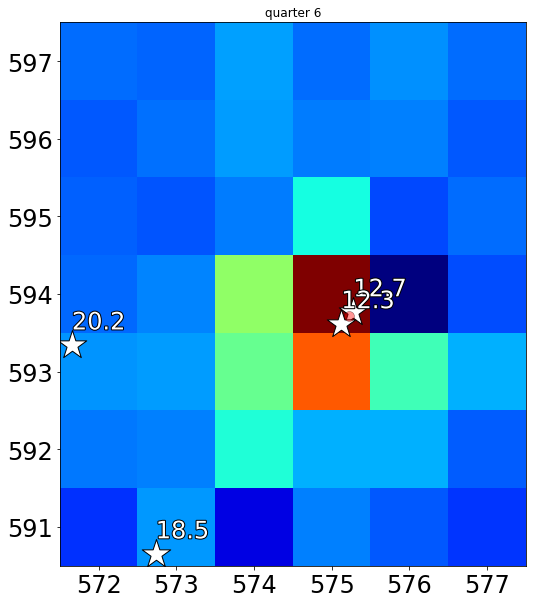

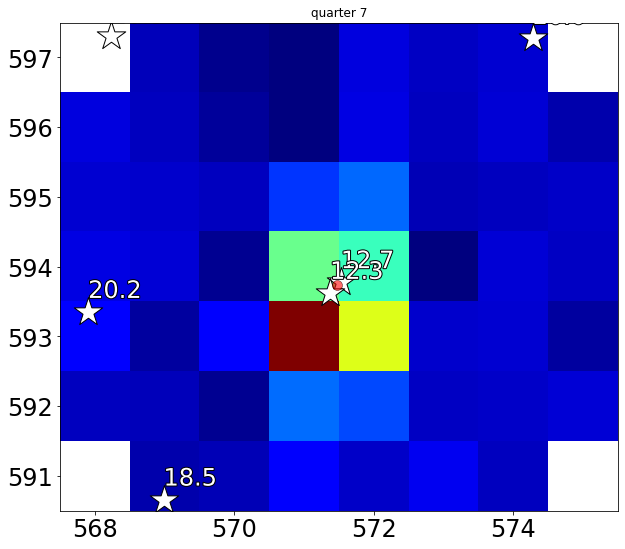

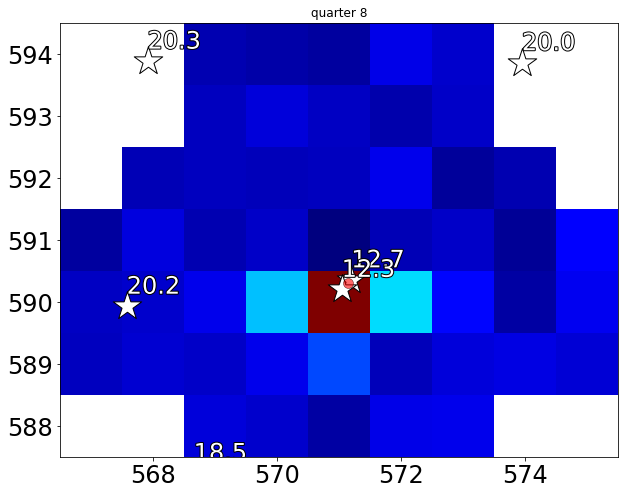

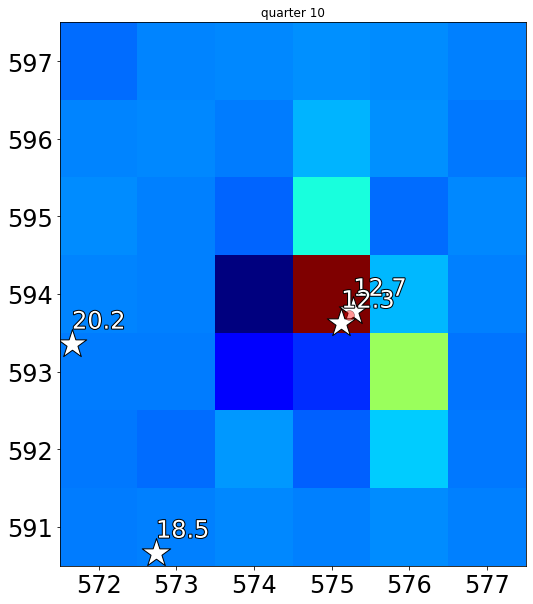

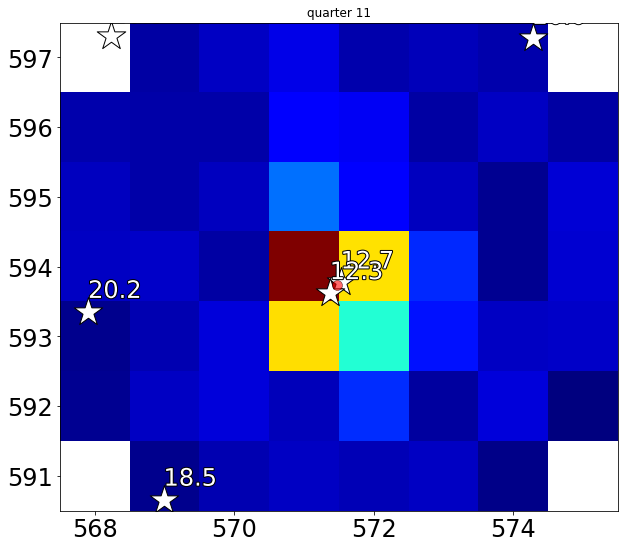

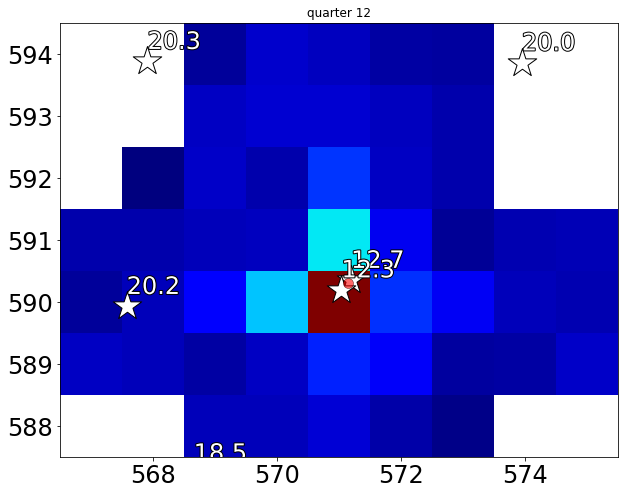

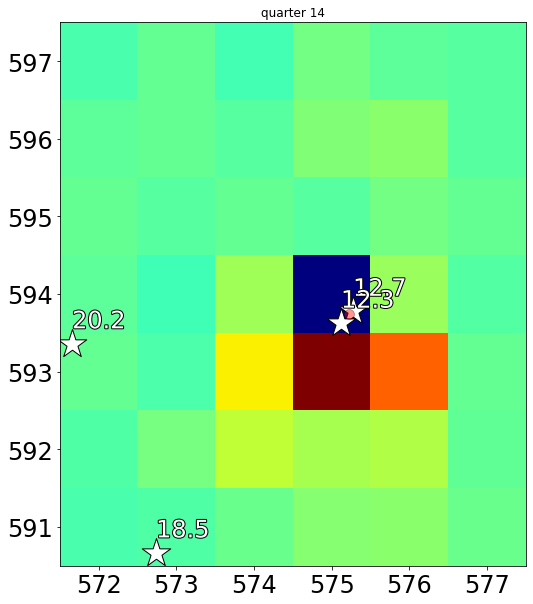

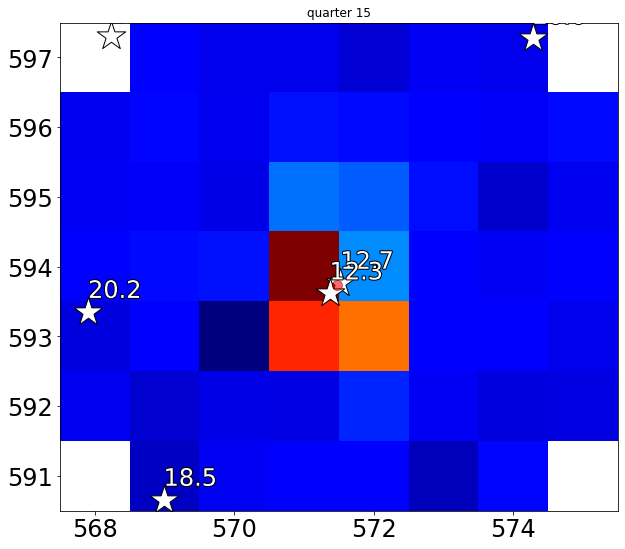

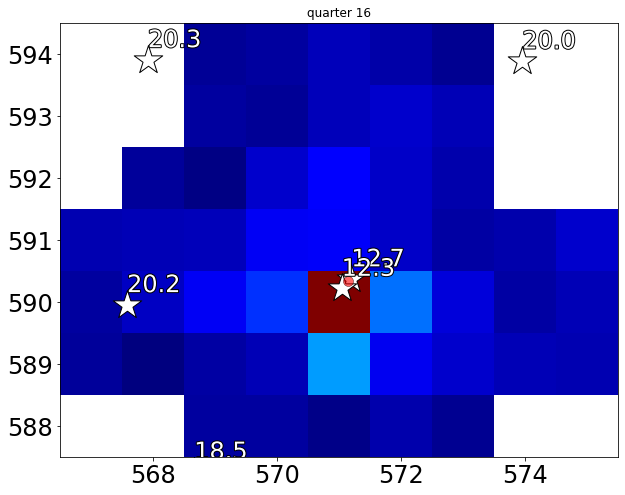

In [5]:
for q in range(len(quarterList)):
    quarterData = quarterDataList[q]
    app.draw_pix_image(allDiffImage[q], quarterData["extent"], quarterData["gaiaCatalog"])
    plt.title("quarter " + str(quarterDataList[q]["quarter"]))

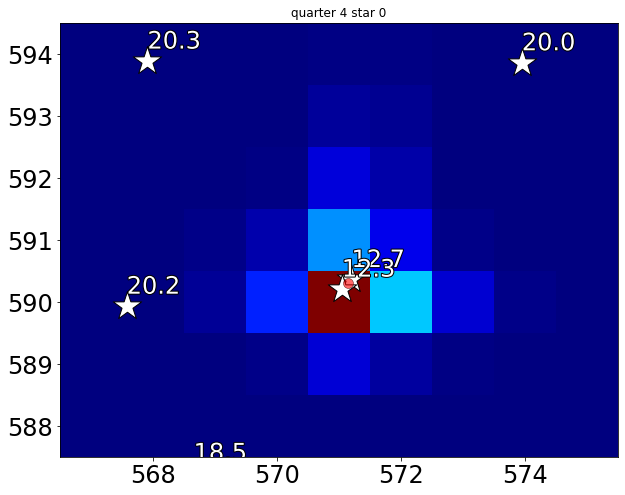

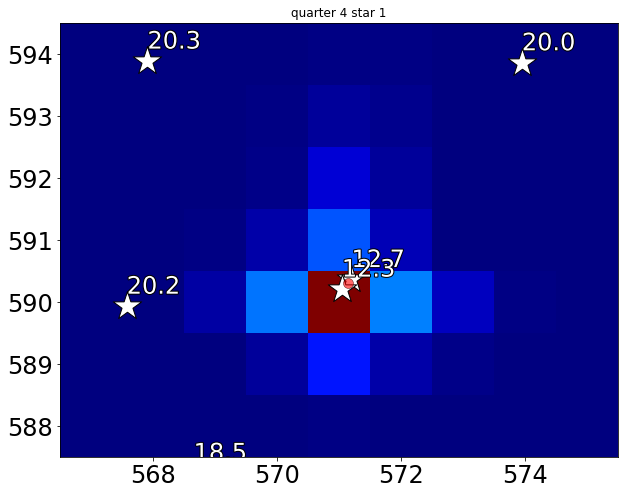

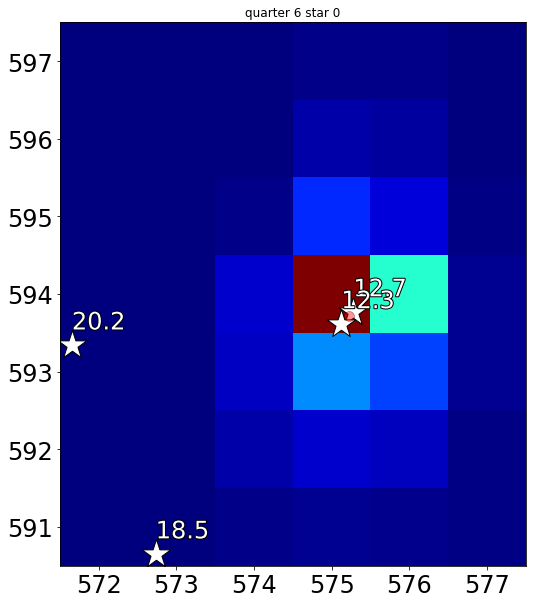

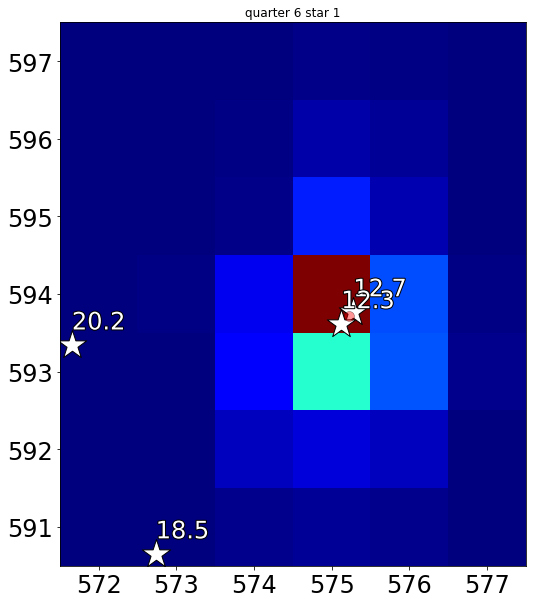

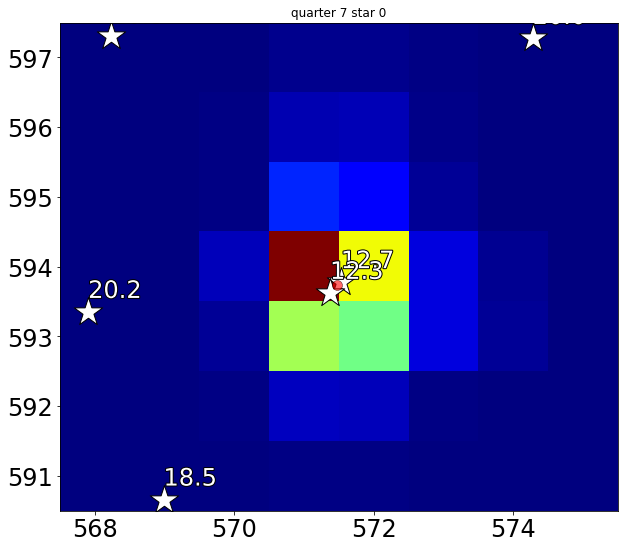

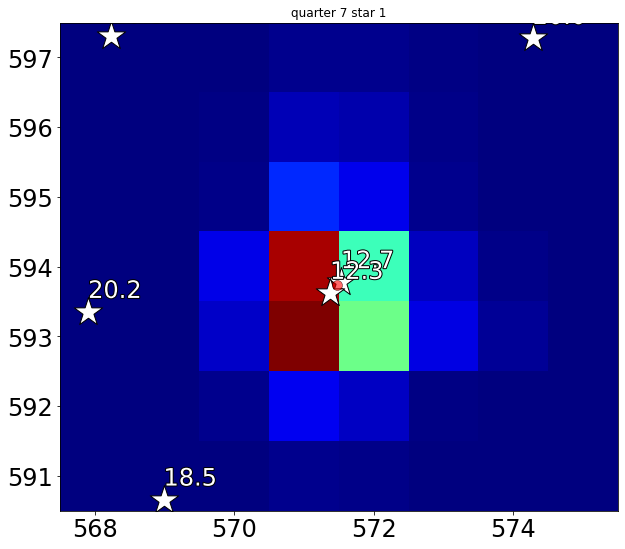

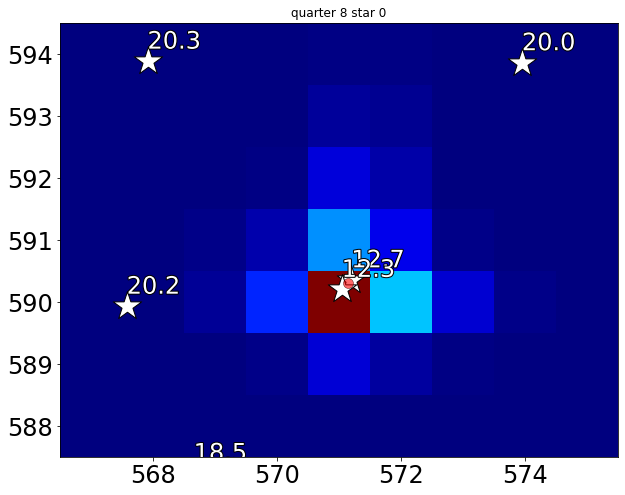

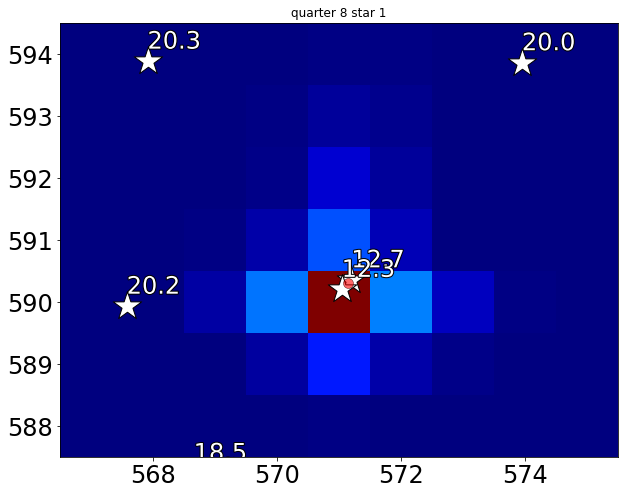

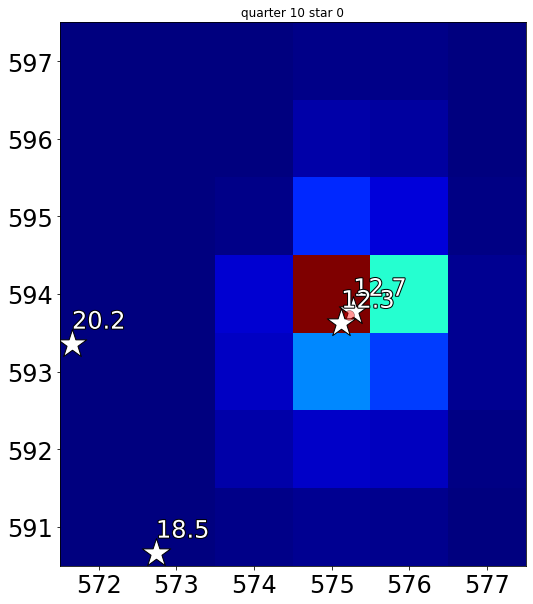

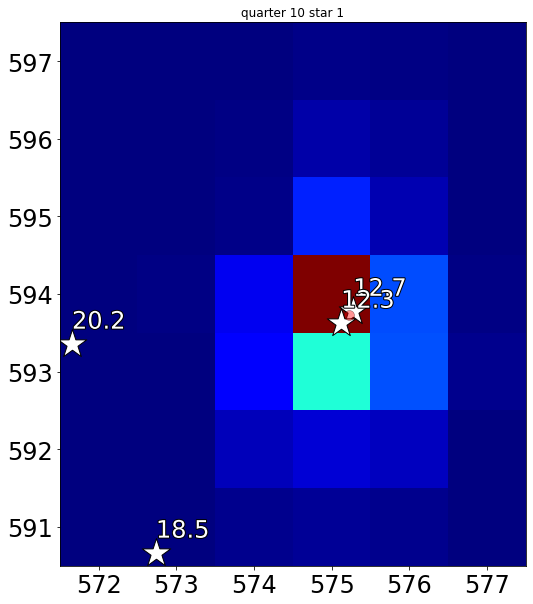

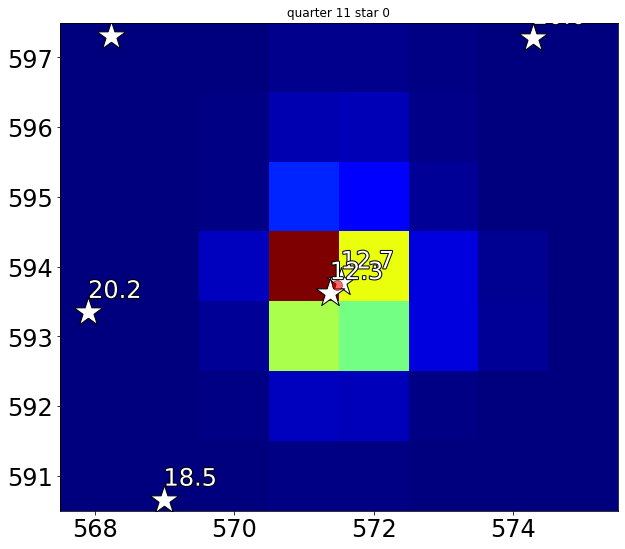

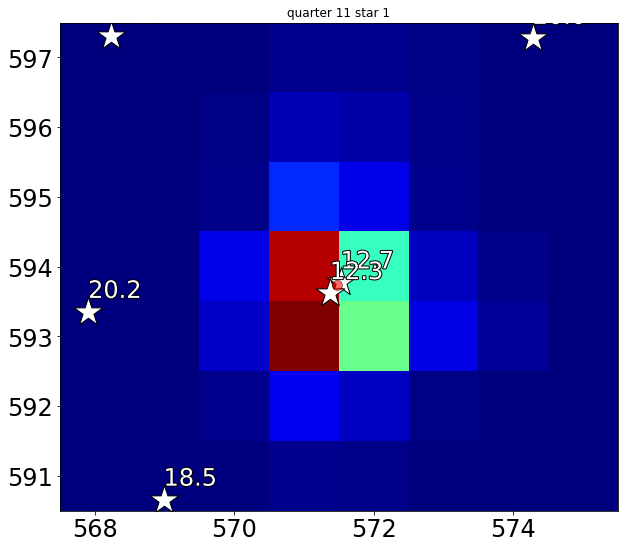

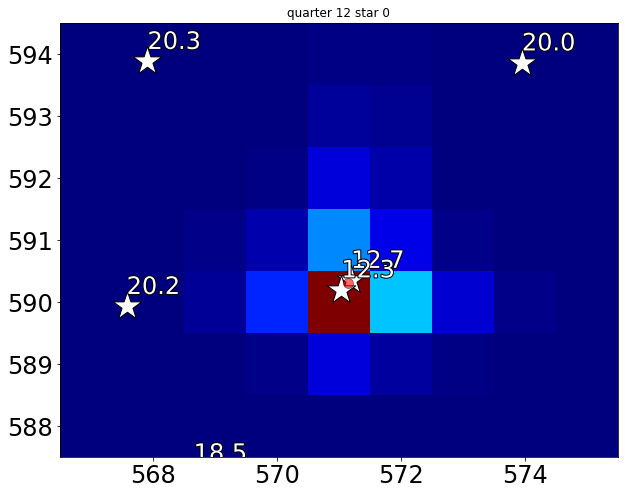

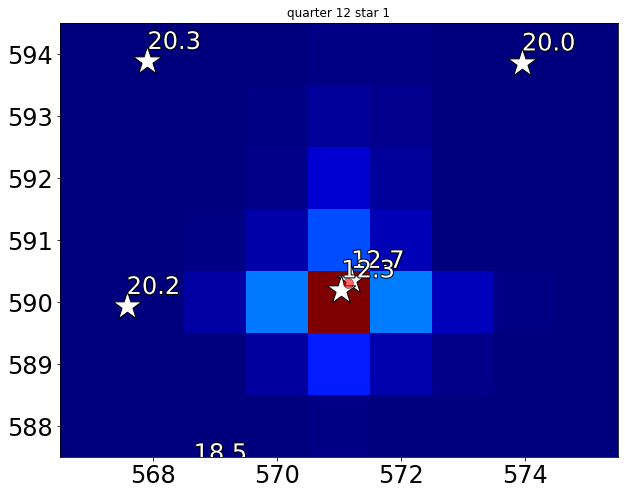

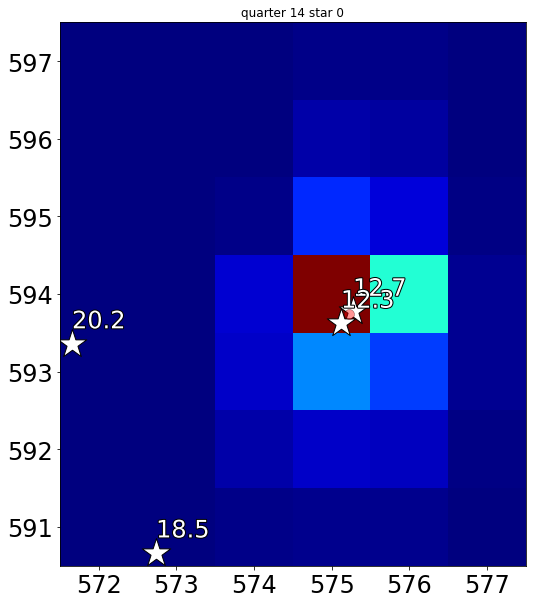

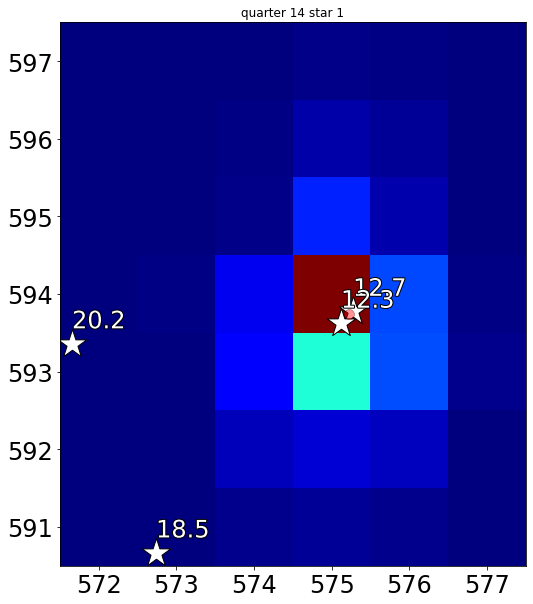

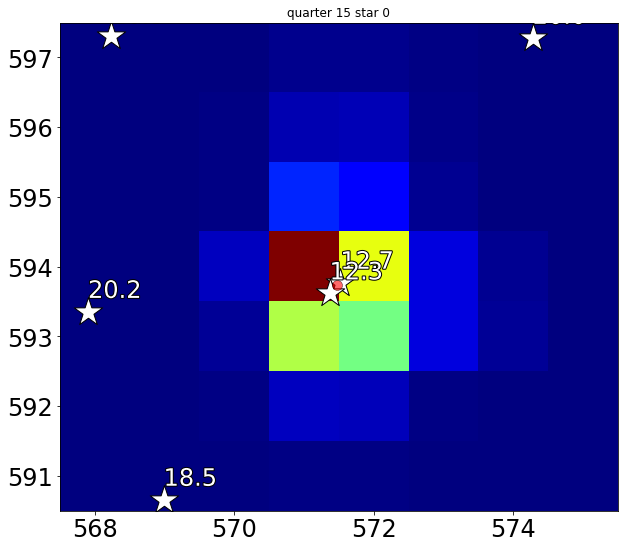

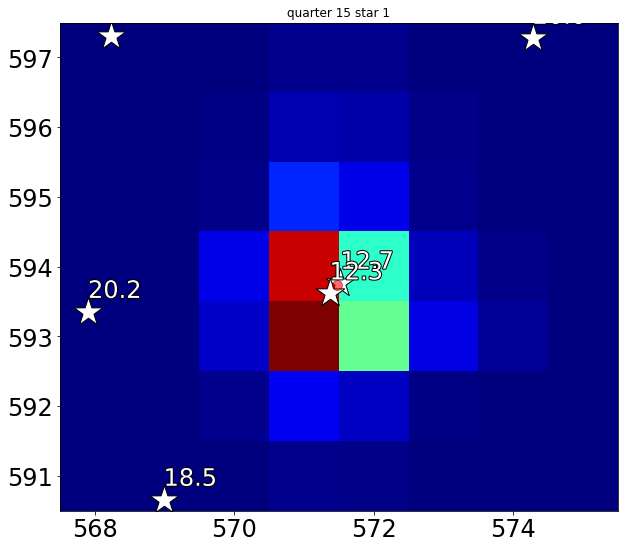

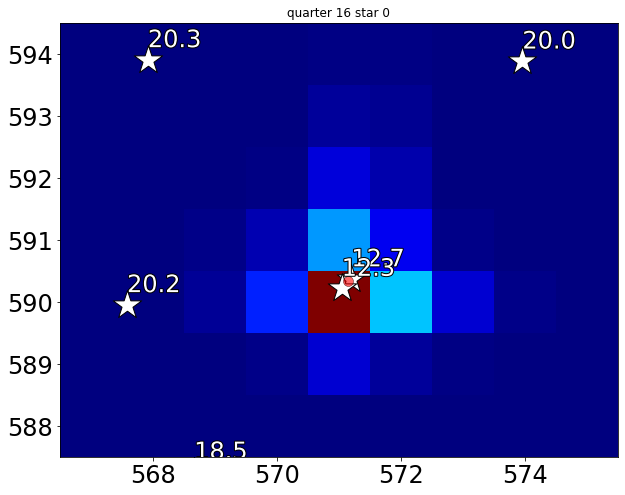

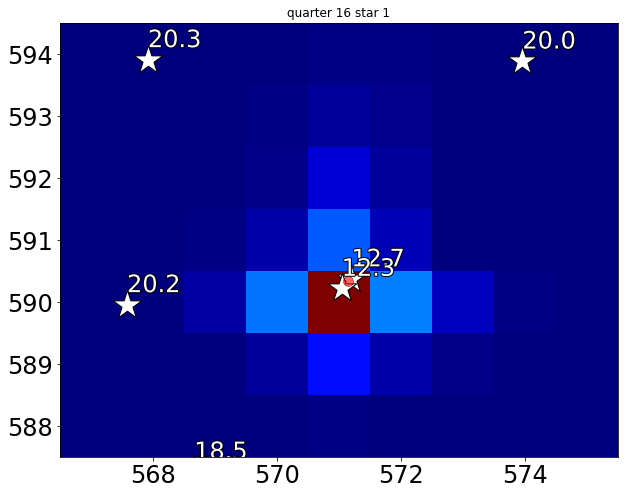

In [6]:
for q in range(len(quarterList)):
    quarterData = quarterDataList[q]
    for s in starList:
        app.draw_pix_image(allSimDiffImage[s][q], quarterData["extent"], quarterData["gaiaCatalog"])
        plt.title("quarter " + str(quarterDataList[q]["quarter"]) + " star " + str(s))

In [7]:
[allDiffImageFlat.shape, allDiffImageSigmaFlat.shape]

[(476,), (476,)]

In [10]:
# bayesian analysis of the close models
import pymc as pm

modelList = []
traceDict = {}
for starIndex in starList:
    with pm.Model() as model:
        model.name = starNames[starIndex]
        modelList.append(model)
        scale = pm.Normal('scale', mu=1, sigma=100)
        sigmaScale = pm.Normal('sigmaScale', mu=1, sigma=100)
        fvect = allSimDiffImageFlat[starIndex]

        fobs = pm.Normal('fobs', 
                         mu=scale*fvect, 
                         sigma=sigmaScale*allDiffImageSigmaFlat, 
                         observed=allDiffImageFlat)

        targetTrace = pm.sample(10000, tune=5000, cores=4, step = pm.Metropolis())
        traceDict[model] = targetTrace


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E::scale]
>Metropolis: [E::sigmaScale]


/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 22 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [W::scale]
>Metropolis: [W::sigmaScale]


/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:289: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 20 seconds.


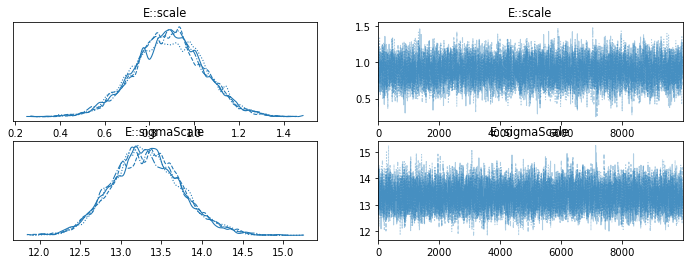

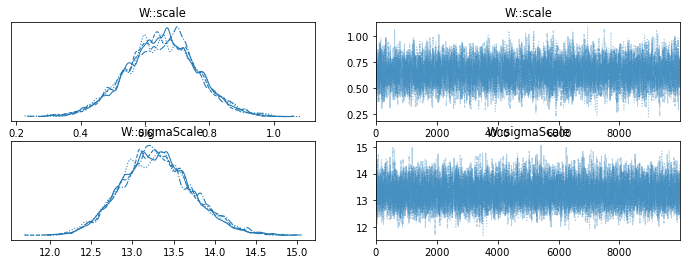

In [12]:
pm.plot_trace(traceDict[modelList[0]], var_names=['E::scale', 'E::sigmaScale']);
pm.plot_trace(traceDict[modelList[1]], var_names=['W::scale', 'W::sigmaScale']);


In [13]:
# dfwaic = pm.compare({onTarget: targetTrace, diffImage1: diffTrace1, diffImage2: diffTrace2}, ic='WAIC')
dfwaic = pm.compare(traceDict, ic='WAIC', method="BB-pseudo-BMA")
dfwaic.index = [k.name for k,v in dfwaic.iterrows()]
dfwaic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
W,0,-1577.289243,3.045960,0.000000,0.656957,28.026620,0.00000,False,log
E,1,-1578.013530,2.965303,0.724288,0.343043,28.114748,0.88043,False,log


Text(0.5, 1.0, 'Kepler-132d')

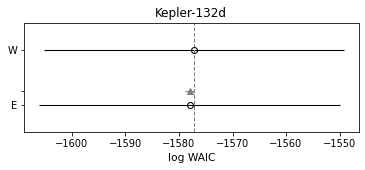

In [14]:
pm.plot_compare(dfwaic, insample_dev=False);
plt.xlabel("log WAIC")
plt.title(koiName)
# plt.savefig(koiName + "_resultComparison.pdf", bbox_inches='tight')

In [ ]:
quarterData["gaiaCatalog"]